In [1]:
import os
import numpy as np
from os import listdir
from matplotlib.pyplot import imread
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2, convolve

from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool


plt.rcParams['figure.figsize'] = (20, 8)

2021-12-11 15:12:34.912250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 15:12:34.912293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
AVAILABLE_CPU = multiprocessing.cpu_count()

In [3]:
# Settings:
img_size = 64
grayscale_images = True
num_class = 10
test_size = 0.2


def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = resize(img, (img_size, img_size, 1 if grayscale_images else 3))
    return img


def get_dataset(dataset_path='Dataset'):
    # Getting all data from data path:
    try:
        X = np.load('X.npy')
        Y = np.load('Y.npy')
    except:
        labels = ['0','1','2','3','4','5','6','7','8','9']  # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path + '/' + label
            for data in listdir(datas_path):
                img = get_img(datas_path + '/' + data)
                X.append(img)
                Y.append(i)
        # Create dateset:
        X = np.array(X).astype('float32')
        Y = np.array(Y).astype('float32')
        Y = to_categorical(Y, num_class)
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    X1, X_test, Y1, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X, Y


if __name__ == '__main__':
    X, Y = get_dataset()

In [4]:
def custom():
    
    Gx = np.array([[-0.25, -0.55, -0.25],[-0.55, 0.9, -0.55], [-0.25, -0.55,-0.25]] )
    return Gx

In [5]:
def customfiltering(img):

    custom_filter = custom()
    smooth_img = conv2(img, custom_filter,mode='same', boundary = 'fill')
    return np.array(smooth_img)

In [6]:
# cleaning
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]
def cleaning(img, rows):
    for row in rows:
        img[row][0:10] = 1
        img[row][53:64] = 1
    return img

In [7]:
def rgb2gray(rgb):
    '''
    RGB -> gray_scale
    '''
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [8]:
def clean_image(image, threshold = 0.5, new_size_tuple = (64,64)):
    new_img = []
    for el in image.flat: 
        if el > threshold: new_img.append(1)
        else: new_img.append(0)
        
    return np.array(new_img).reshape(new_size_tuple)

In [9]:
print(Y[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
img = X[1]
    
new_img = clean_image(img)

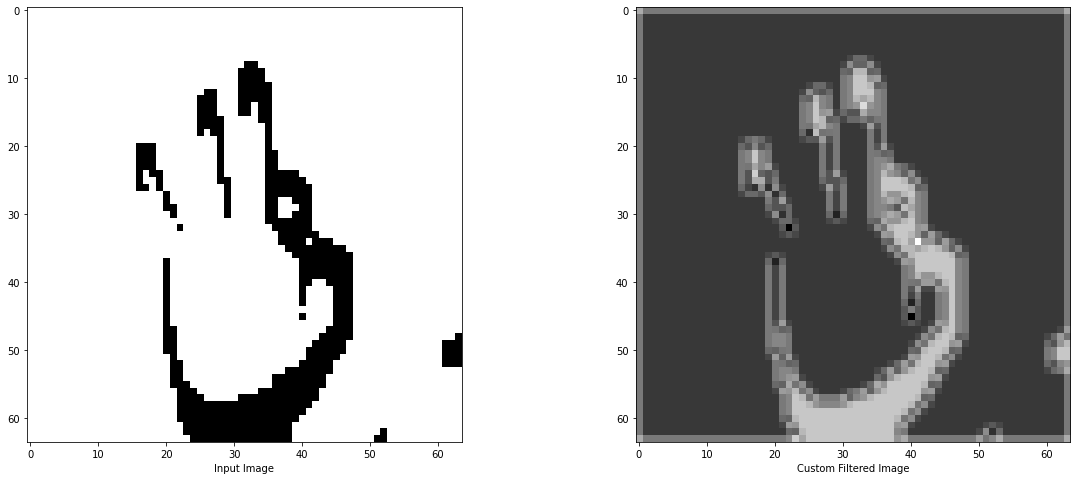

In [11]:
img = cleaning(new_img, subset)
smooth_img = customfiltering(img)
#print(smooth_img.shape)
plt.figure(2)
ax1 = plt.subplot(1,2,1)
ax1.set_xlabel('Input Image')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel('Custom Filtered Image')
plt.sca(ax1)
plt.imshow(img, cmap='gray')
plt.sca(ax2)
plt.imshow(smooth_img, cmap='gray')
plt.show()

In [12]:

# let's split the dataset into relative matrix

y_v_amounts = {}
priorsDictionary = {}
tot_y = len(Y)

# compute priors
for y_i in Y:
    idx = str(np.where(y_i == 1)[0][0])
    
    if(idx in list(priorsDictionary.keys())):
        y_v_amounts[idx] += 1
        priorsDictionary[idx] += 1/tot_y
    else:
        y_v_amounts[idx] = 1
        priorsDictionary[idx] = 1/tot_y

print(priorsDictionary)

vals = list(priorsDictionary.values())
assert(np.round(np.sum(vals)) == 1), f"Priors don't sum up to 1! Their sum is...: {np.sum(vals)}"

{'0': 0.0989330746847718, '1': 0.09941804073714813, '2': 0.09990300678952446, '3': 0.10038797284190079, '4': 0.09990300678952446, '5': 0.10087293889427712, '6': 0.10038797284190079, '7': 0.09990300678952446, '8': 0.09990300678952446, '9': 0.10038797284190079}


In [13]:
priors2Dictionary = {}
for i in range(10):
    priors2Dictionary[str(i)] = 1/10
priors2Dictionary   

{'0': 0.1,
 '1': 0.1,
 '2': 0.1,
 '3': 0.1,
 '4': 0.1,
 '5': 0.1,
 '6': 0.1,
 '7': 0.1,
 '8': 0.1,
 '9': 0.1}

In [14]:
def compute_ground_matrix_couple(index, y_i, X):
    '''
    This takes as input the index of a groundtruth and the groundtruth itself aswell as the dataset.
    First it finds the image in position [y_i], 
    it then computes its cleaned matrix and returns it as a key value pair.
    '''
    
    ground_truth = str(np.where(y_i == 1)[0][0])
    image = clean_image(X[index])
    print(f"image {image}")
    return (ground_truth, image)


def matrix_addition(A, B) :
    return [[A[i][j] + B[i][j]  for j in range(len(A[0]))] for i in range(len(A))]

def extract_Y_indexes_with_label(Y,label) :
    hot_vec = np.zeros(10)
    hot_vec[label] = 1
    indexes = []
    for idx, el in enumerate(Y) :
        if ((el == hot_vec).all()) :
            indexes.append(idx)
    return indexes

def compute_likelihood_mt(Y, X):
    '''
    This works similar to a map reduce approach:
    it finds every image for every ground truth and then zips them into a singular one which becomes of probabilities.
    '''
    lhoods = {}
    for i in range(10) :
        lhoods[i] = (np.mean(X[extract_Y_indexes_with_label(Y,i)], axis=0))

    return lhoods


# using map

    
    

In [15]:
## TEST ONLY

likeDict = {}
# initialize posteriors matrixes
for key in priorsDictionary.keys():
    likeDict[key] = np.array(X[0].shape)

# compute posteriors for every image in the dataset
likes = compute_likelihood_mt(Y,X)



KeyError: '0'

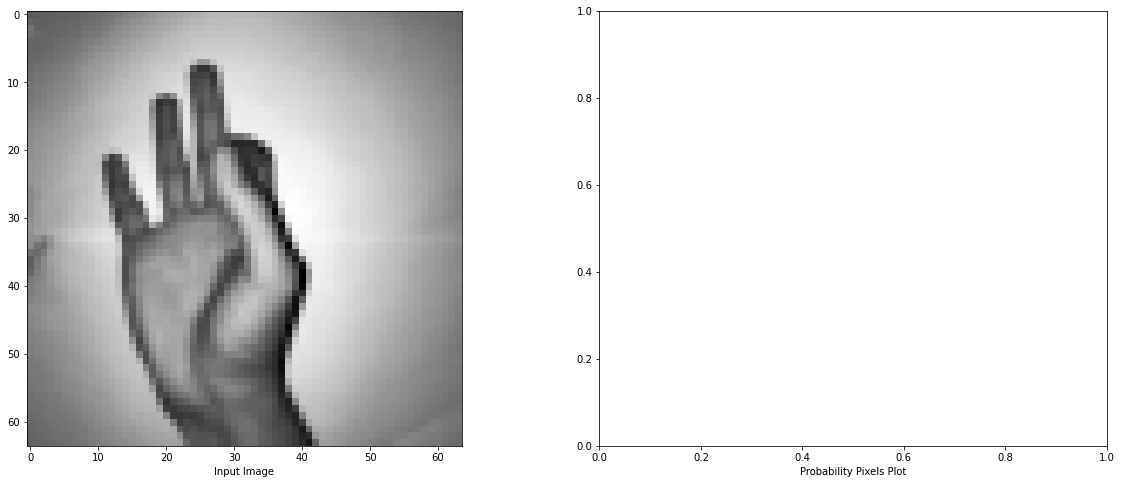

In [16]:
for idx in range(10):
    image_0 = X[idx]
    #print(smooth_img.shape)
    plt.figure(2)
    ax1 = plt.subplot(1,2,1)
    ax1.set_xlabel('Input Image')
    ax2 = plt.subplot(1,2,2)
    ax2.set_xlabel('Probability Pixels Plot')
    plt.sca(ax1)
    plt.imshow(image_0, cmap='gray')
    plt.sca(ax2)
    plt.imshow(likes[str(np.where(Y[idx] == 1)[0][0])], cmap='gray')
    plt.show()

In [17]:
class NaiveBayesClassifier :
    
    def __init__(self, use_gaussian = 0, verbose = 0) :
        self.GAUSSIAN = use_gaussian
        self.verbose = verbose
        self._classes = None
        self._n_classes = 0
        self._eps = np.finfo(np.float32).eps

        self._class_priors = []
        self._likelihoods = {}
        self._gaussian_likelihoods = {}
        
    def fit(self, X_Train, Y_Train, lr_mi=1, lr_sigma2=1):
        '''
        this computes the priors and likelihoods for the classifier. 
        '''     
        # let's split the dataset into relative matrix
        y_v_amounts = {}
        priorsDictionary = {}
        tot_y = len(Y_Train)
        # compute priors
        for y_i in Y_Train:
            idx = str(np.where(y_i == 1)[0][0])
            if(idx in list(priorsDictionary.keys())):
                y_v_amounts[idx] += 1
                priorsDictionary[idx] += 1/tot_y
            else:
                y_v_amounts[idx] = 1
                priorsDictionary[idx] = 1/tot_y
        if(self.verbose):
            print("Computed priors :")
            print(priorsDictionary)
            
        vals = list(priorsDictionary.values())
        assert(np.round(np.sum(vals)) == 1), f"Priors don't sum up to 1! Their sum is...: {np.sum(vals)}"
        
        self._classes = y_v_amounts.keys()
        self._n_classes = len(list(y_v_amounts.keys()))
        self._class_priors = priorsDictionary
        
        if self.verbose:
            for i in range(self._n_classes):
                print("la classe {} ha prior={}".format(self._classes[i], self._class_priors[self._classes[i]]))
            print("\n")
            
        # compute likelihoods
        if( self.GAUSSIAN ) :
            mu_dict = compute_likelihood_mt(Y_Train, X_Train)
            for i in range(0,10) :
                mu = mu_dict[i] * lr_mi
                indexes = extract_Y_indexes_with_label(Y, i)
                sigma2 = np.mean(np.square(X_Train[indexes] - mu), axis=0) * lr_sigma2
                dist = (1 / np.sqrt(2 * np.pi * sigma2)) * 1 / (np.exp(np.square(X_Train[indexes] - mu) / (2 * sigma2)))
                likely = np.sum(np.log(dist), axis=0)
                self._gaussian_likelihoods[i] = likely
                
        else :
            self._likelihoods = compute_likelihood_mt(Y_Train, X_Train)
        
        
        

In [18]:
classifier = NaiveBayesClassifier(use_gaussian=1)

classifier.fit(X, Y)

In [19]:
print(classifier._class_priors)

{'0': 0.0989330746847718, '1': 0.09941804073714813, '2': 0.09990300678952446, '3': 0.10038797284190079, '4': 0.09990300678952446, '5': 0.10087293889427712, '6': 0.10038797284190079, '7': 0.09990300678952446, '8': 0.09990300678952446, '9': 0.10038797284190079}


In [20]:
print(classifier._classes)

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [21]:
print(classifier._gaussian_likelihoods)

{0: array([[157.65294, 159.81729, 163.21031, ..., 149.76306, 150.61478,
        152.37694],
       [163.61635, 164.86568, 170.74896, ..., 156.61739, 154.05298,
        153.94205],
       [169.56007, 172.40494, 177.8115 , ..., 161.22095, 158.66156,
        157.66467],
       ...,
       [216.50302, 217.82993, 218.11044, ..., 188.60503, 185.40971,
        180.53491],
       [213.58604, 215.6355 , 215.91002, ..., 184.22096, 180.9903 ,
        176.1576 ],
       [213.53336, 215.77348, 216.41946, ..., 180.99045, 177.55757,
        173.54877]], dtype=float32), 1: array([[149.03738, 150.49149, 153.12729, ..., 140.34174, 140.7862 ,
        142.74606],
       [151.918  , 155.66457, 159.28506, ..., 139.80191, 137.80891,
        138.29349],
       [149.09622, 152.36214, 156.39095, ..., 143.70372, 141.13893,
        140.33217],
       ...,
       [171.68825, 174.13664, 175.94415, ..., 173.53978, 171.85258,
        168.97824],
       [169.98584, 172.36635, 174.83128, ..., 171.4321 , 170.48439,
    

In [22]:
Y = np.where(Y==1)[1]
permutation = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
for i in range(len(Y)):
    Y[i] = permutation[Y[i]]

In [23]:
threshold = 0.5
Xbw = [clean_image(X[i], threshold = threshold) for i in range(len(X))]

In [24]:
Xbw = np.array([Xbw[i].flatten() for i in range(len(X))])

In [29]:
Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)

In [26]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


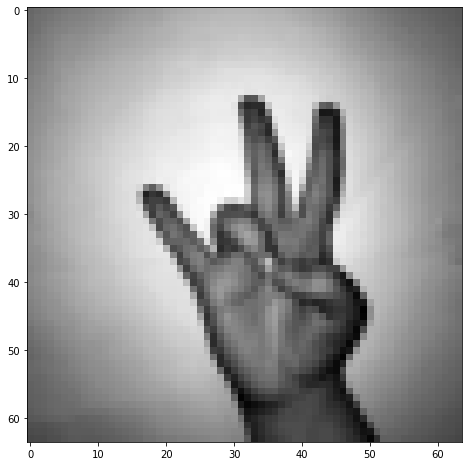

In [12]:
idx = 600
print(Y[idx])
plt.imshow(X[idx], cmap='gray', interpolation='nearest')

In [ ]:
model = GaussianNB()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=LeaveOneOut())

In [ ]:
modelbw = MultinomialNB()
modelbw.fit(Xbwtrain, Ytrain)
scorebw = cross_val_score(modelbw, Xbw, Y, cv=LeaveOneOut())

In [145]:
score.mean()

0.6314258001939864

In [33]:
scorebw.mean()

0.48544861873270484

In [138]:
accuracy_score(Ytest,Ymodel)

0.43992248062015504

In [116]:
mat = confusion_matrix(Ymodel,Ytest)

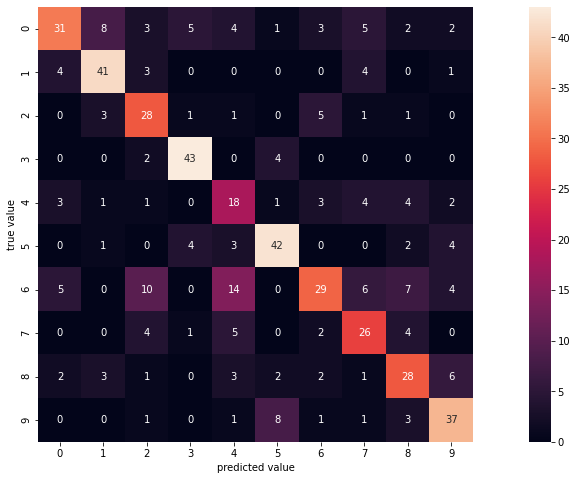

In [117]:
import seaborn as sns

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

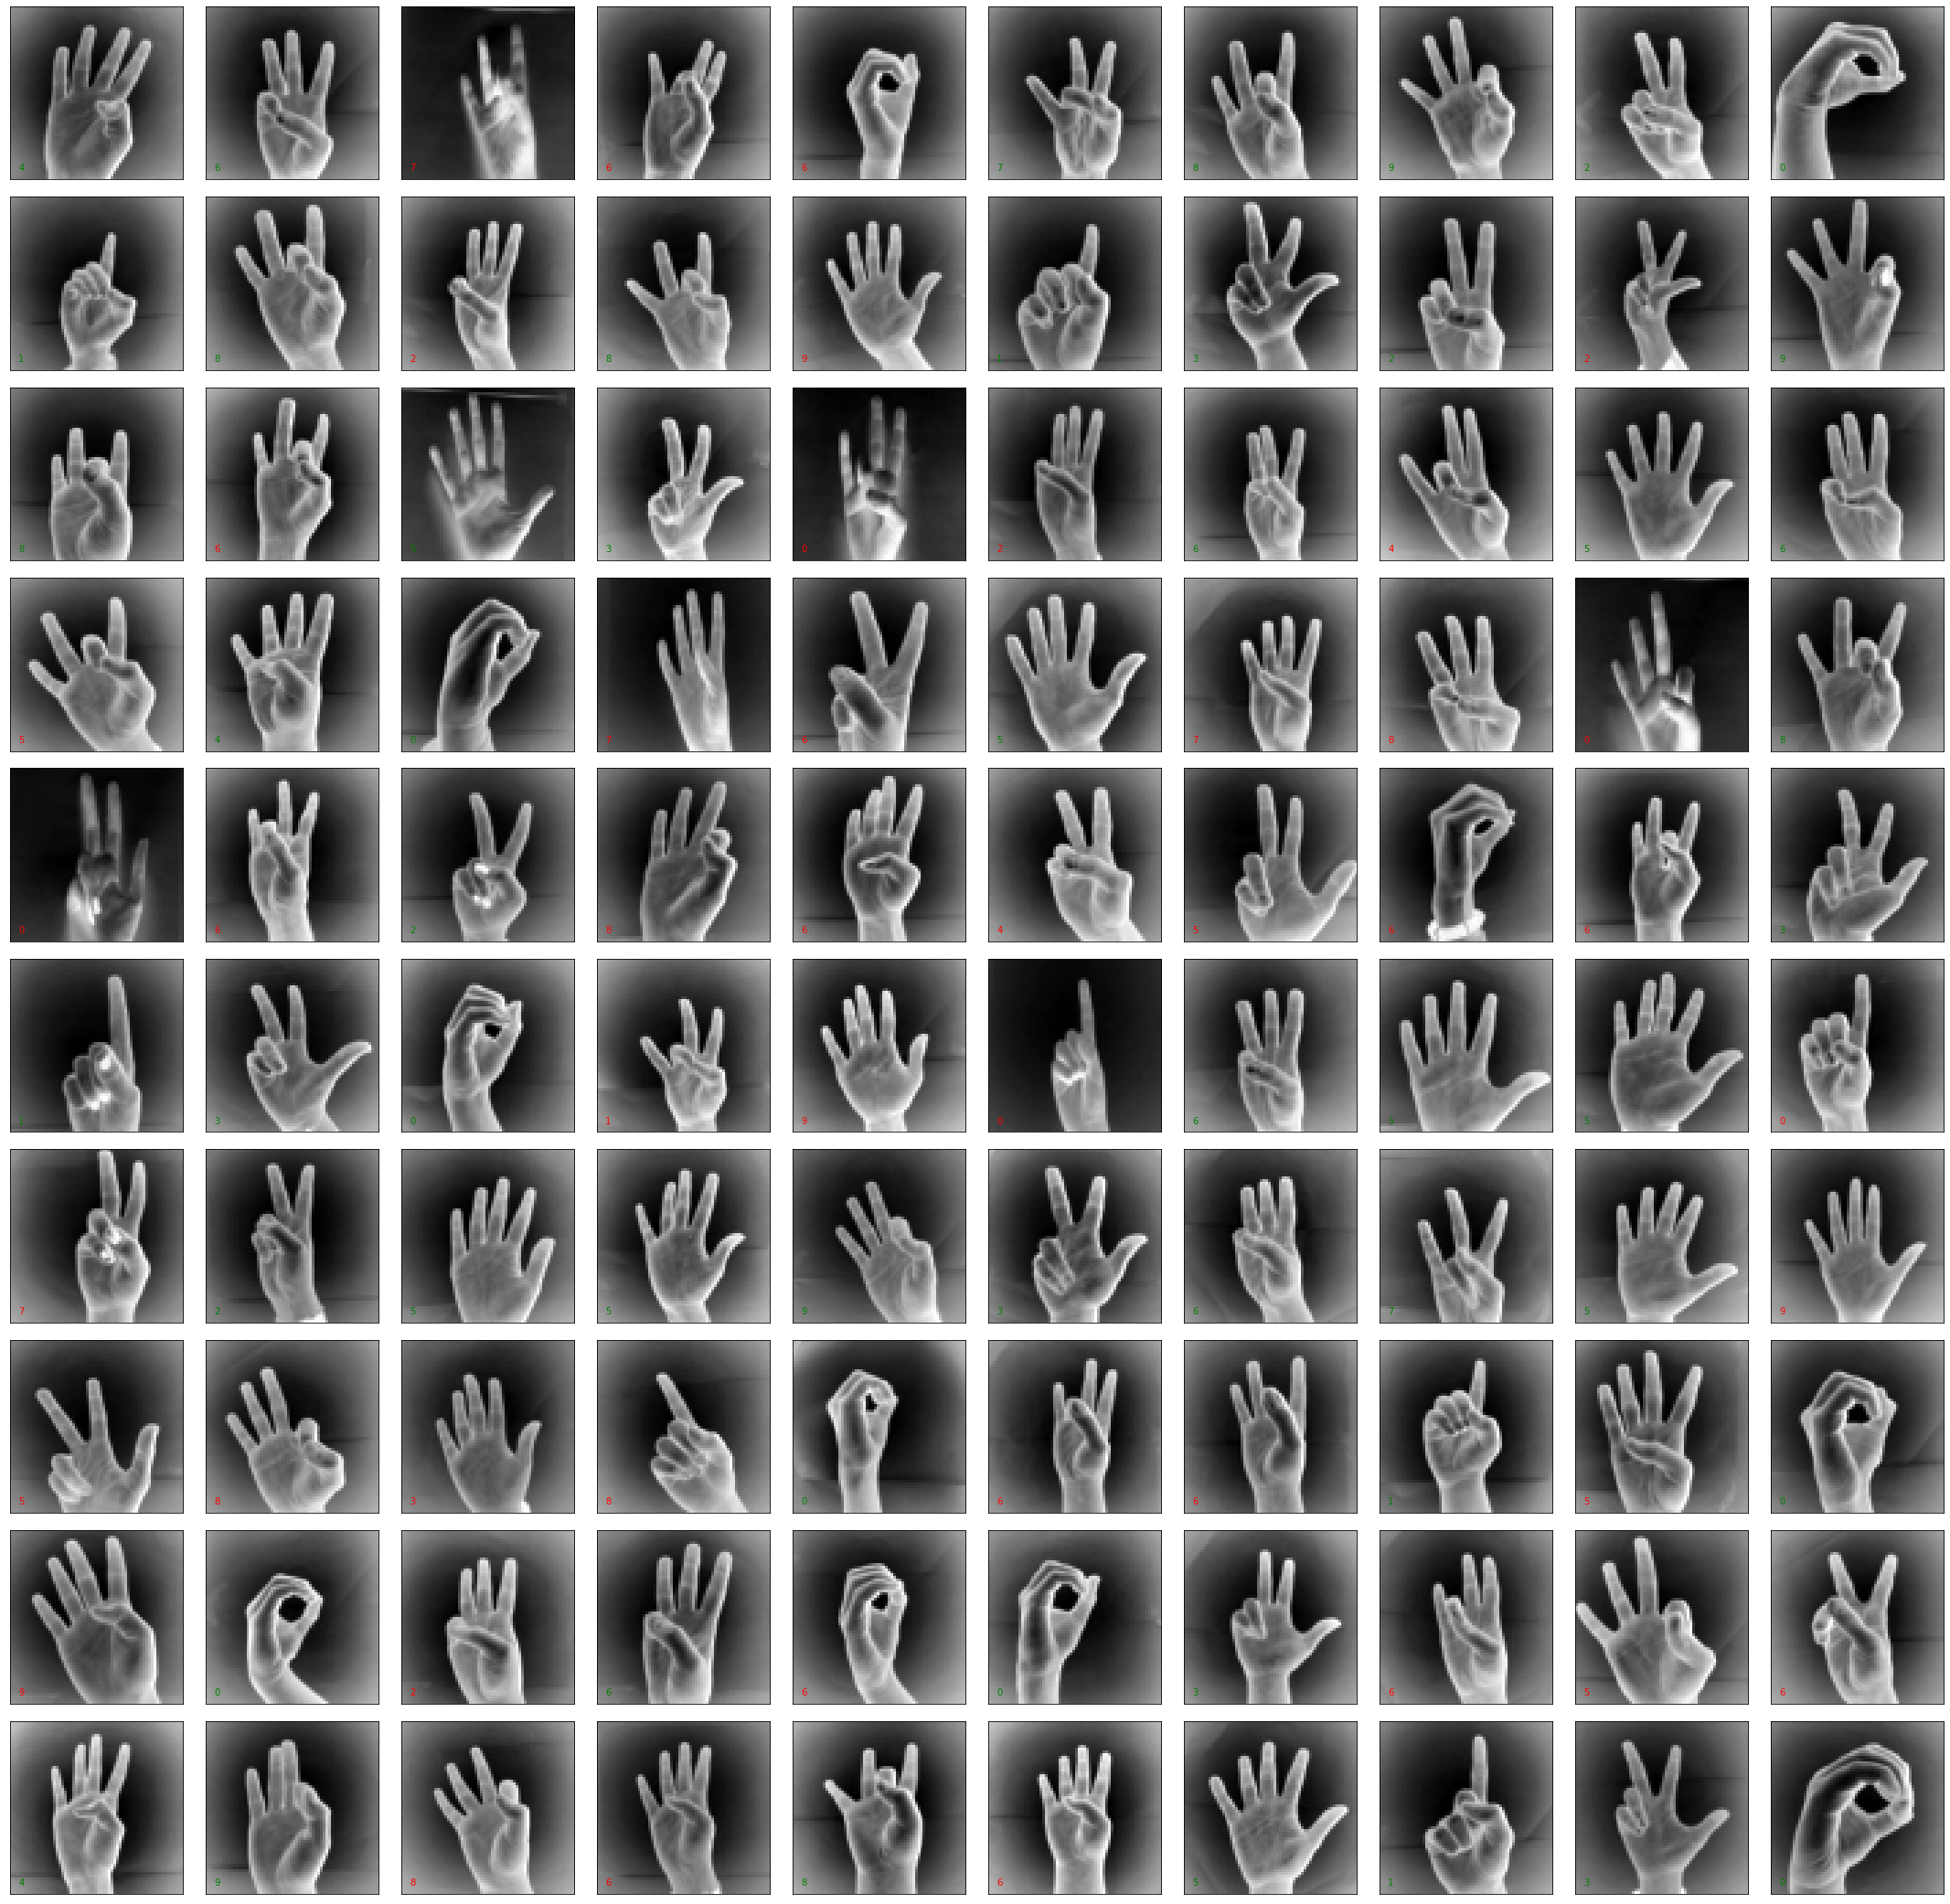

In [119]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes,
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

In [71]:
X_test.shape

(413, 4096)

In [91]:
X_test.shape

(413, 4096)

In [76]:
Y_test = np.where(Y_test==1)[1]